In [28]:
import openmc
import matplotlib.pyplot as plt
from openmc.deplete import Results
integrator_types = ('predictor', 'cecm')
time_types = ('minutes', 'hours', 'days', 'months')
normalization_types = ('source_rate', 'fission_q')
depletion_types = ('simple', 'full')
chain_files = ('../openmc/tests/chain_simple.xml','chain_endbf71_pwr.xml')

In [47]:
time_type = 0
integrator_type = 0
normalization_type = 1
depletion_type = 0
chain_file = 0

time_type = time_types[time_type]
integrator_type = integrator_types[integrator_type]
normalization_type = normalization_types[normalization_type]
depletion_type = depletion_types[depletion_type]
chain_file = chain_files[chain_file]

case1_results = Results(f'case1/{integrator_type}/{depletion_type}_depletion_results_{time_type}.h5')
case2_results = Results(f'case2/{integrator_type}/{depletion_type}_depletion_results_{time_type}.h5')

path = f'case3/{integrator_type}/{depletion_type}_depletion_results_{time_type}_'
results0 = Results(path + '0.h5')
results1 = Results(path + '1.h5')
results2 = Results(path + '2.h5')
results3 = Results(path + '3.h5')
results4 = Results(path + '4.h5')
results5 = Results(path + '5.h5')

#alt_results = [results0, results1, results2, results3, results4, results5]

#t = alt_case3_results[0].time
#j = 0
#for result in alt_results:
#    for i, res in enumerate(result):
#        k = i + j
#        times=[0,0]
#        times[0] = t[1] * k
#        times[1] = t[1] * (k+1)
#    j += 1

case3_results = Results()
case3_results.append(results0[0])
case3_results.append(results1[0])
case3_results.append(results2[0])
case3_results.append(results3[0])
case3_results.append(results4[0])
case3_results.append(results5[0])
case3_results.append(results5[1])

t = results0[0].time
for i, res in enumerate(case3_results):
    times = [0,0]
    times[0] = t[1] * i
    times[1] = t[1] * (i+1)
    res.time = times
    
time, _ = case1_results.get_atoms("1", "U235")
chain = openmc.deplete.Chain.from_xml(chain_file)
atoms_dict = {}
rx_dict = {}
for nuc in chain.nuclide_dict:
    atoms = (case1_results.get_atoms("1", nuc)[1], 
             case2_results.get_atoms("1", nuc)[1],
             case3_results.get_atoms("1", nuc)[1])
    atoms_dict[nuc] = atoms
    rx_dict.update({nuc: {}})
    for rx in chain.reactions:
        reactions = (case1_results.get_reaction_rate('1', nuc, rx)[1],
                     case2_results.get_reaction_rate('1', nuc, rx)[1],
                     case3_results.get_reaction_rate('1', nuc, rx)[1])
        rx_dict[nuc].update({rx: reactions})
        
atoms_dict.keys()

dict_keys(['I135', 'Xe135', 'Xe136', 'Cs135', 'Gd157', 'Gd156', 'U234', 'U235', 'U238'])

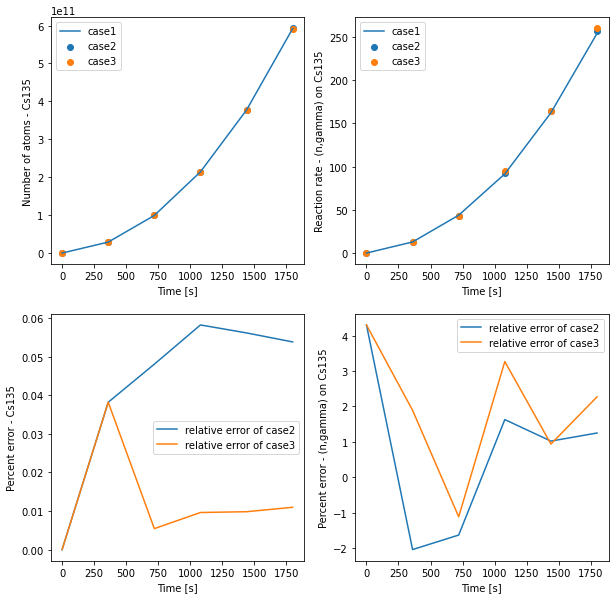

In [48]:
nuc = 'Cs135'
rx = '(n,gamma)'
i = -1
j = -1
c1_atoms, c2_atoms, c3_atoms = atoms_dict[nuc]
c1_nuc_rx, c2_nuc_rx, c3_nuc_rx = rx_dict[nuc][rx]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

ax1.plot(time[:i], c1_atoms[:i], label="case1")
ax1.scatter(time[:i], c2_atoms[:i], label="case2")
ax1.scatter(time[:i], c3_atoms[:i], label="case3")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel(f"Number of atoms - {nuc}");
ax1.legend()

at_error21 = 100 * (c2_atoms - c1_atoms) / c1_atoms
at_error31 = 100 * (c3_atoms - c1_atoms) / c1_atoms
at_error23 = 100 * (c2_atoms - c3_atoms) / c3_atoms
ax3.plot(time[:j], at_error21[:j], label="relative error of case2")
ax3.plot(time[:j], at_error31[:j], label="relative error of case3")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel(f"Percent error - {nuc}")
ax3.legend()

ax2.plot(time[:i], c1_nuc_rx[:i], label="case1")
ax2.scatter(time[:i], c2_nuc_rx[:i], label="case2")
ax2.scatter(time[:i], c3_nuc_rx[:i], label="case3")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel(f"Reaction rate - {rx} on {nuc}");
ax2.legend()

rx_error21 = 100 * (c2_nuc_rx - c1_nuc_rx) / c1_nuc_rx
rx_error31 = 100 * (c3_nuc_rx - c1_nuc_rx) / c1_nuc_rx
rx_error23 = 100 * (c2_nuc_rx - c3_nuc_rx) / c3_nuc_rx
ax4.plot(time[:j], rx_error21[:j], label="relative error of case2")
ax4.plot(time[:j], rx_error31[:j], label="relative error of case3")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel(f"Percent error - {rx} on {nuc}")
ax4.legend()

In [44]:
(c2_nuc_rx - c1_nuc_rx) / c1_nuc_rx

array([0.06110273, 0.0548872 , 0.02667296, 0.06899801, 0.04670193,
       0.02770364, 0.07175573])

In [45]:
((c2_nuc_rx / c2_atoms) - (c1_nuc_rx / c1_atoms)) / (c1_nuc_rx / c1_atoms)

array([0.06110273, 0.05491215, 0.02661244, 0.06883964, 0.04643419,
       0.02737008, 0.07134917])

In [17]:
c2_nuc_rx

array([2.40511572e-10, 2.40512371e-10, 2.40513169e-10, 2.40513968e-10,
       2.40514766e-10, 2.40515564e-10, 2.40516363e-10])

In [18]:
c1_nuc_rx

array([2.30599178e-07, 1.28308325e+01, 4.37874837e+01, 9.15447708e+01,
       1.62266635e+02, 2.53973204e+02, 3.87392459e+02])

In [916]:
(c2_atoms - c1_atoms) / c1_atoms

array([ 0.        , -0.00100965, -0.00304065, -0.00282023, -0.00355758,
       -0.00322698, -0.00259827])

In [933]:
alt_c3_nuc_rx

array([2.40511572e-07, 1.09552547e+01, 3.82847315e+01, 8.36267004e+01,
       1.48805241e+02, 2.23363391e+02, 3.25124777e+02])

In [934]:
c1_nuc_rx

array([2.30599178e-07, 1.28308325e+01, 4.37874837e+01, 9.15447708e+01,
       1.62266635e+02, 2.53973204e+02, 3.87392459e+02])

In [935]:
c3_nuc_rx

array([2.40511572e-07, 1.25687455e+01, 3.75430917e+01, 8.19219556e+01,
       1.45704559e+02, 2.28234246e+02, 3.32061723e+02])

In [27]:
case2_results.export_to_materials(0)[0].get_nuclide_atom_densities()

/home/ooblack/projects/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/ooblack/projects/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/ooblack/projects/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


OrderedDict([('U236', 0.000197052043966672),
             ('O16', 1.999242),
             ('O17', 0.000758),
             ('Cs135', 1.0000000000000001e-21),
             ('Gd156', 1.0000000000000001e-21),
             ('Gd157', 1.0000000000000001e-21),
             ('I135', 1.0000000000000001e-21),
             ('U234', 8.922411359424314e-06),
             ('U235', 0.0009982401918608218),
             ('U238', 0.022192386373095892),
             ('Xe135', 1.0000000000000001e-21),
             ('Xe136', 1.0000000000000001e-21)])

In [8]:
mat = openmc.Materials.from_xml('materials.xml')

/home/ooblack/projects/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/ooblack/projects/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/ooblack/projects/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


In [26]:
mat[0].get_nuclide_atom_densities()

OrderedDict([('U234', 8.922411359424316e-06),
             ('U235', 0.000998240191860822),
             ('U238', 0.022192386373095892),
             ('U236', 4.572419549506112e-06),
             ('O16', 0.04639065406771322),
             ('O17', 1.7588724018066158e-05)])

In [10]:
dilmat = openmc.Materials.from_xml('diluted_materials.xml')

/home/ooblack/projects/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/ooblack/projects/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/ooblack/projects/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


In [23]:
dilmat[0].get_nuclide_atom_densities()

OrderedDict([('U234', 8.922411359424316e-06),
             ('U235', 0.000998240191860822),
             ('U238', 0.022192386373095892),
             ('U236', 4.572419549506111e-06),
             ('O16', 0.04639065406771322),
             ('O17', 1.7588724018066158e-05),
             ('I135', 1e-21),
             ('Xe135', 1e-21),
             ('Xe136', 1e-21),
             ('Cs135', 1e-21),
             ('Gd157', 1e-21),
             ('Gd156', 1e-21)])